In [54]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_2par as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value

import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch

def reset_matplotlib():
    # Reset all matplotlib settings to defaults
    mpl.rcdefaults()

    # Create a default handler map and update it globally
    default_handler_map = {
        mpl.lines.Line2D: HandlerLine2D(numpoints=1),
        mpl.patches.Patch: HandlerPatch()
    }

    # Update the default handler map globally
    mpl.legend.Legend.update_default_handler_map(default_handler_map)

# Call this function at the start of your script to globally reset settings
reset_matplotlib()

import getpass
uname = getpass.getuser()
figtype = None #"notebook"

# plt.style.use('default')
import scienceplots
if uname == 'darkknight':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 185/1.75*1.2})
elif uname == 'brian':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 254})
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.rcParams.update({'font.serif': 'Times', 'font.family' : 'serif'})


[CpuDevice(id=0)]


In [25]:
# Ground stuff
n_freq = 2000
fmin = 10.
fmax = 1000.
freqs = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))


full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))

psd = lib.read_mag(freqs, "curves/o3_l1.txt")**2
# psd = lib.read_mag(freqs, "../curves/ce1.txt")**2

data_150914 = np.array(data[0])
data_150914[0] = 30
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390





In [26]:
red_param = dict(zip(names, jnp.array(data[0]).T))
get_dh_H1  = jax.jit(lib.get_dh_H1)
get_dh_L1  = jax.jit(lib.get_dh_L1)
get_dh_V1  = jax.jit(lib.get_dh_V1)

get_h_H1   = jax.jit(lib.get_h_H1)
get_h_L1   = jax.jit(lib.get_h_L1)
get_h_V1   = jax.jit(lib.get_h_V1)

a = get_dh_H1(red_param, freqs)
a = get_dh_L1(red_param, freqs)
a = get_dh_V1(red_param, freqs)
a = get_h_H1(red_param, freqs)
a = get_h_L1(red_param, freqs)
a = get_h_V1(red_param, freqs)
# dh_L1  = get_dh_L1(red_param, freqs)
# dh_V1  = get_dh_V1(red_param, freqs)

In [27]:
kk = [-2,3]

def calc_FI_main(idx, kk):
    names_ppe = names + [f"phi_{k}" for k in kk]


    idx_par =  {names_ppe[i] : i for i in range(len(names_ppe))} # indexes for fisher matrix
    log_flag =  {names_ppe[i] : 0 for i in range(len(names_ppe))} # I want the derivate to be wrt log M_c and log Dl
    log_flag["M_c"] = 1; log_flag["d_L"] = 1
    if idx=='150914':
        dat = jnp.array(data_150914)
    
    red_param = dict(zip(names, jnp.array(dat).T))

    dh_H1  = get_dh_H1(red_param, freqs)
    dh_L1  = get_dh_L1(red_param, freqs)
    dh_V1  = get_dh_V1(red_param, freqs)
    
    h_H1   = get_h_H1(red_param, freqs)
    h_L1   = get_h_L1(red_param, freqs)
    h_V1   = get_h_V1(red_param, freqs)

    for k in kk:
        dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
        dh_H1[f"phi_{k}"] = 1j*dpsi_ppe*h_H1
        dh_L1[f"phi_{k}"] = 1j*dpsi_ppe*h_L1
        dh_V1[f"phi_{k}"] = 1j*dpsi_ppe*h_V1
    
    fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_par, psd, log_flag)
    fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_par, psd, log_flag)
    fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_par, psd, log_flag)
    fi = fi_H1 + fi_L1 + fi_V1
    return fi, names_ppe

fi, names_ppe = calc_FI_main('150914',kk)
jnp.diag(sla.inv(fi))

Array([5.04986065e-03, 2.68149579e-04, 3.25700841e-01,
       2.79666069e-04, 2.63782366e-04, 7.25581574e-01,
       1.05245587e+00, 1.13504149e-07, 4.67058320e+00,
       3.85677333e-05, 1.88171057e-04], dtype=float64)

In [28]:
def compute_bias(dh, dh_nvnl, psd, freqs, idx_par):
    res = { key : jnp.real(lib.innprod(dh[key], dh_nvnl, psd, freqs)) for key in dh.keys()}
    # res = { key : jnp.real(lib.innprod(dh[key], dh_nvnl, psd, freqs)) for key in dh.keys()}
    # bias = jnp.zeros(len(idx_par))
    # for idx in idx_par:
    #     bias[idx_par[idx]] = res[idx]
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]

    bias = jnp.real(jnp.array(bias))
    return bias

In [29]:
kk = [2]
idx = '150914'
names_ppe = names + [f"phi_{k}" for k in kk]


idx_par =  {names_ppe[i] : i for i in range(len(names_ppe))} # indexes for fisher matrix
log_flag =  {names_ppe[i] : 0 for i in range(len(names_ppe))} # I want the derivate to be wrt log M_c and log Dl
log_flag["M_c"] = 1; log_flag["d_L"] = 1
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))

dh_H1  = get_dh_H1(red_param, freqs)
dh_L1  = get_dh_L1(red_param, freqs)
dh_V1  = get_dh_V1(red_param, freqs)

h_H1   = get_h_H1(red_param, freqs)
h_L1   = get_h_L1(red_param, freqs)
h_V1   = get_h_V1(red_param, freqs)

for k in kk:
    dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
    dh_H1[f"phi_{k}"] = 1j*dpsi_ppe*h_H1
    dh_L1[f"phi_{k}"] = 1j*dpsi_ppe*h_L1
    dh_V1[f"phi_{k}"] = 1j*dpsi_ppe*h_V1

fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_par, psd, log_flag)
fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_par, psd, log_flag)
fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_par, psd, log_flag)
fi = fi_H1 + fi_L1 + fi_V1



In [30]:
names_para = names

idx_par =  {names_para[i] : i for i in range(len(names_para))} # indexes for fisher matrix
log_flag =  {names_para[i] : 0 for i in range(len(names_para))} # I want the derivate to be wrt log M_c and log Dl
log_flag["M_c"] = 1; log_flag["d_L"] = 1
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names_para, jnp.array(dat).T))

dh_H1  = get_dh_H1(red_param, freqs)
dh_L1  = get_dh_L1(red_param, freqs)
dh_V1  = get_dh_V1(red_param, freqs)

h_H1   = get_h_H1(red_param, freqs)
h_L1   = get_h_L1(red_param, freqs)
h_V1   = get_h_V1(red_param, freqs)

fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_par, psd, log_flag)
fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_par, psd, log_flag)
fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_par, psd, log_flag)
fi = fi_H1 + fi_L1 + fi_V1

dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, 3)

IP_j = compute_bias(dh_H1, 1j*dpsi_ppe*h_H1, psd, freqs, idx_par) + compute_bias(dh_L1, 1j*dpsi_ppe*h_L1, psd, freqs, idx_par) + compute_bias(dh_V1, 1j*dpsi_ppe*h_V1, psd, freqs, idx_par)
IP_j = np.array(IP_j)
lam = IP_j @ sla.inv(fi)
dh = np.array([dh_H1[s] for s in idx_par])

dhppe = 1j*dpsi_ppe*h_H1
dhperp =  (dhppe - lam @ dh)
dhpara = lam @ dh

dpsi = dpsi_ppe
dpsiperp = dhperp/ (1j * h_H1)
dpsipara = dhpara/ (1j * h_H1)



In [63]:
def get_projections(sub_par, red_param, deltapsi):
    idx_subpar = {sub_par[i] : i for i in range(len(sub_par))}
    log_flag_subpar = log_flag.copy()
    

    h_H1   = get_h_H1(red_param, freqs)
    h_L1   = get_h_L1(red_param, freqs)
    h_V1   = get_h_V1(red_param, freqs)

    dhperp = np.zeros((len(freqs)), dtype=np.complex128)
    dhpara = np.zeros((len(freqs)), dtype=np.complex128)
    
    dpsiperp = np.zeros((len(freqs)))
    dpsipara = np.zeros((len(freqs)))
    # fi_H1, fi_L1, fi_V1
    # fi_H1, fi_L1, fi_V1 = lib.get_FI_ppe(freqs, red_param, idx_subpar, psd, log_flag, k)
    


    dh_H1  = get_dh_H1(red_param, freqs)
    dh_L1  = get_dh_L1(red_param, freqs)
    dh_V1  = get_dh_V1(red_param, freqs)

    phi_keys = [key for key in sub_par if key.startswith('phi_')]
    for phik in phi_keys:
        k = int(phik.split('_')[1])
        dpsi_ppe = lib.get_dpsi_ppe(freqs, red_param, k)
        dh_H1[phik] = 1j*dpsi_ppe*h_H1
        dh_L1[phik] = 1j*dpsi_ppe*h_L1
        dh_V1[phik] = 1j*dpsi_ppe*h_V1
        log_flag_subpar[phik] = 0
    # print(sub_par)
    fi_H1 = lib.fish(freqs, dh_H1, red_param, idx_subpar, psd, log_flag_subpar)
    fi_L1 = lib.fish(freqs, dh_L1, red_param, idx_subpar, psd, log_flag_subpar)
    fi_V1 = lib.fish(freqs, dh_V1, red_param, idx_subpar, psd, log_flag_subpar)
    fi = fi_H1 + fi_L1 + fi_V1

    for i in log_flag_subpar.keys():
        if log_flag_subpar[i]:
            # h_H1[idx_par[i]] = h_H1[idx_par[i]] * red_param[i]
            dh_H1[i] = dh_H1[i] * red_param[i]
            dh_L1[i] = dh_L1[i] * red_param[i]
            dh_V1[i] = dh_V1[i] * red_param[i]



    V = compute_bias(dh_H1,1j*deltapsi*h_H1, psd, freqs, idx_subpar) + compute_bias(dh_L1,1j*deltapsi*h_L1, psd, freqs, idx_subpar) + compute_bias(dh_V1,1j*deltapsi*h_V1, psd, freqs, idx_subpar)
    V = np.array(V)
    
    
    dh = np.array([dh_H1[s] for s in sub_par])
    lam = V @ sla.inv(fi)
    
    

    dhtot = 1j*deltapsi*h_H1
    dhperp =  (dhtot - lam @ dh)
    dhpara = lam @ dh
    
    dpsi = deltapsi
    dpsiperp = dhperp/ (1j * h_H1)
    dpsipara = dhpara/ (1j * h_H1)

    return dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam

# dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam = get_projections(names, red_param, lib.get_dpsi_ppe(freqs, red_param, 3))


In [64]:
names_ppe
phi_keys = [key for key in names_ppe if key.startswith('phi_')]
for phik in phi_keys:
    print(int(phik.split('_')[1]))

2


/home/darkknight/anaconda3/envs/qmstruct/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


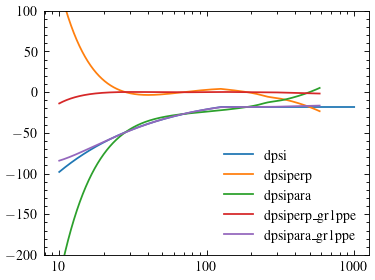

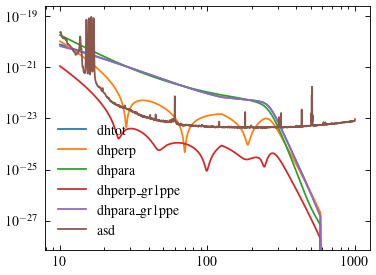

In [77]:
dhtot, dhperp, dhpara, dpsi, dpsiperp, dpsipara, lam = get_projections(names, red_param, lib.get_dpsi_ppe(freqs, red_param, 3))
dhtot, dhperp_gr1ppe, dhpara_gr1ppe, dpsi, dpsiperp_gr1ppe, dpsipara_gr1ppe, lam = get_projections(names_ppe, red_param, lib.get_dpsi_ppe(freqs, red_param, 3))

plt.semilogx(freqs, dpsi, label='dpsi')
plt.plot(freqs, dpsiperp, label='dpsiperp')
plt.plot(freqs, dpsipara, label='dpsipara')
plt.plot(freqs, dpsiperp_gr1ppe, label='dpsiperp_gr1ppe')
plt.plot(freqs, dpsipara_gr1ppe, label='dpsipara_gr1ppe')
plt.ylim(bottom = -200,top = 100)
plt.legend(loc = 0,handler_map=None)
plt.show()

f = np.array(freqs)
plt.loglog(f, np.abs(dhtot), label='dhtot')
plt.plot(f, np.abs(dhperp), label='dhperp')
plt.plot(f, np.abs(dhpara), label='dhpara')
plt.plot(f, np.abs(dhperp_gr1ppe), label='dhperp_gr1ppe')
plt.plot(f, np.abs(dhpara_gr1ppe), label='dhpara_gr1ppe')
plt.plot(f, psd**(1/2), label='asd')
plt.legend(loc = 0,handler_map=None)
plt.show()

In [ ]:


plt.semilogx(freqs, dpsi, label='dpsi')
plt.plot(freqs, dpsiperp_gr1ppe, label='dpsiperp')
plt.plot(freqs, dpsipara_gr1ppe, label='dpsipara')
plt.ylim(bottom = -200,top = 100)
plt.legend(loc = 0,handler_map=None)
plt.show()

plt.loglog(freqs, np.abs(dhtot), label='dhtot')
plt.plot(freqs, np.abs(dhperp_gr1ppe), label='dhperp')
plt.plot(freqs, np.abs(dhpara_gr1ppe), label='dhpara')
plt.plot(freqs, psd**(1/2), label='asd')
plt.legend(loc = 0,handler_map=None)
plt.show()

In [5]:
# def calc_FI(idx, k):
#     red_param = dict(zip(names, jnp.array(data[idx]).T))
    
#     fi_H1, fi_L1, fi_V1 = lib.get_FI_ppe(freqs, red_param, idx_par, psd, log_flag, k)

#     fi = fi_H1 + fi_L1 + fi_V1
#     return fi

In [6]:
# kk = [0,3]
# fun = lambda idx : calc_FI(idx, k)
# fun_jit = jax.jit(fun)

In [7]:
# red_param = dict(zip(names, jnp.array(data[1]).T))
